In [1]:
!nvidia-smi

Fri Feb 20 19:00:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               On  |   00000000:1B:00.0 Off |                  Off |
| 41%   53C    P8             39W /  140W |       1MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import datetime
import os

import numpy as np
from torch.utils.data import Subset, DataLoader

from leaf_seg.common.loss.cedice import CEDiceLoss
from leaf_seg.dataset.plantdreamer_semantic import build_dataloaders, build_dataset
from leaf_seg.semantic.build import build_optimiser, build_reporter, build_scheduler, setup_model
from leaf_seg.semantic.train import fit, run
from leaf_seg.semantic.finetune import finetune, load_pretrained_weights
from leaf_seg.semantic.config import SemanticTrainConfig, SemanticFinetuneConfig

/home/psyqc1/miniforge3/envs/leaf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def make_fixed_subset(dataset, fraction=None, n=None, seed=0):
    assert (fraction is None) ^ (n is None), "Specify exactly one of fraction or n"
    rng = np.random.default_rng(seed)

    N = len(dataset)
    k = int(round(N * fraction)) if fraction is not None else int(n)
    k = max(1, min(N, k))

    idx = rng.permutation(N)[:k].tolist()
    return Subset(dataset, idx)

In [4]:
from IPython.display import clear_output, display, Image as IPyImage
from pathlib import Path
import pandas as pd

def attach_notebook_viz(reporter, *, tail=10, show_png=True, show_csv=True):
    """
    Wrap reporter.log_epoch so that after each epoch it refreshes notebook output.
    """
    orig_log_epoch = reporter.log_epoch
    out_dir = Path(reporter.output_dir)
    csv_path = out_dir / "results.csv"
    png_path = out_dir / "results.png"

    def log_epoch_with_viz(epoch, epochs, train_stats, val_stats, lr):
        # run original logging (writes CSV/PNG)
        orig_log_epoch(epoch, epochs, train_stats, val_stats, lr)

        # now display artifacts
        clear_output(wait=True)

        if show_csv and csv_path.exists():
            try:
                df = pd.read_csv(csv_path)
                display(df.tail(tail))
            except Exception as e:
                print(f"Could not read {csv_path}: {e}")

        if show_png and png_path.exists():
            display(IPyImage(filename=str(png_path), width=840))
        elif show_png:
            print(f"Plot not found yet: {png_path}")

    reporter.log_epoch = log_epoch_with_viz
    return reporter

,epoch,train/loss,val/loss,metrics/mean_iou,metrics/mean_dice,metrics/overall_acc,metrics/mean_acc,metrics/freqw_acc,lr,time/train,time/val,time/epoch
82,83.0,0.125111,0.136217,0.775764,0.854776,0.988967,0.860639,0.980075,0.000003,1.141136,1.812685,2.953822
83,84.0,0.119041,0.136450,0.775829,0.854666,0.989034,0.858637,0.980152,0.000003,1.139704,1.854598,2.994301
84,85.0,0.120158,0.135966,0.776065,0.854759,0.989073,0.858569,0.980216,0.000003,1.188092,1.847793,3.035885
85,86.0,0.109456,0.134476,0.777062,0.855621,0.989055,0.863923,0.980267,0.000003,1.153198,1.792249,2.945446
86,87.0,0.115040,0.134002,0.777924,0.856369,0.989023,0.869455,0.980293,0.000003,1.156632,1.799509,2.956141


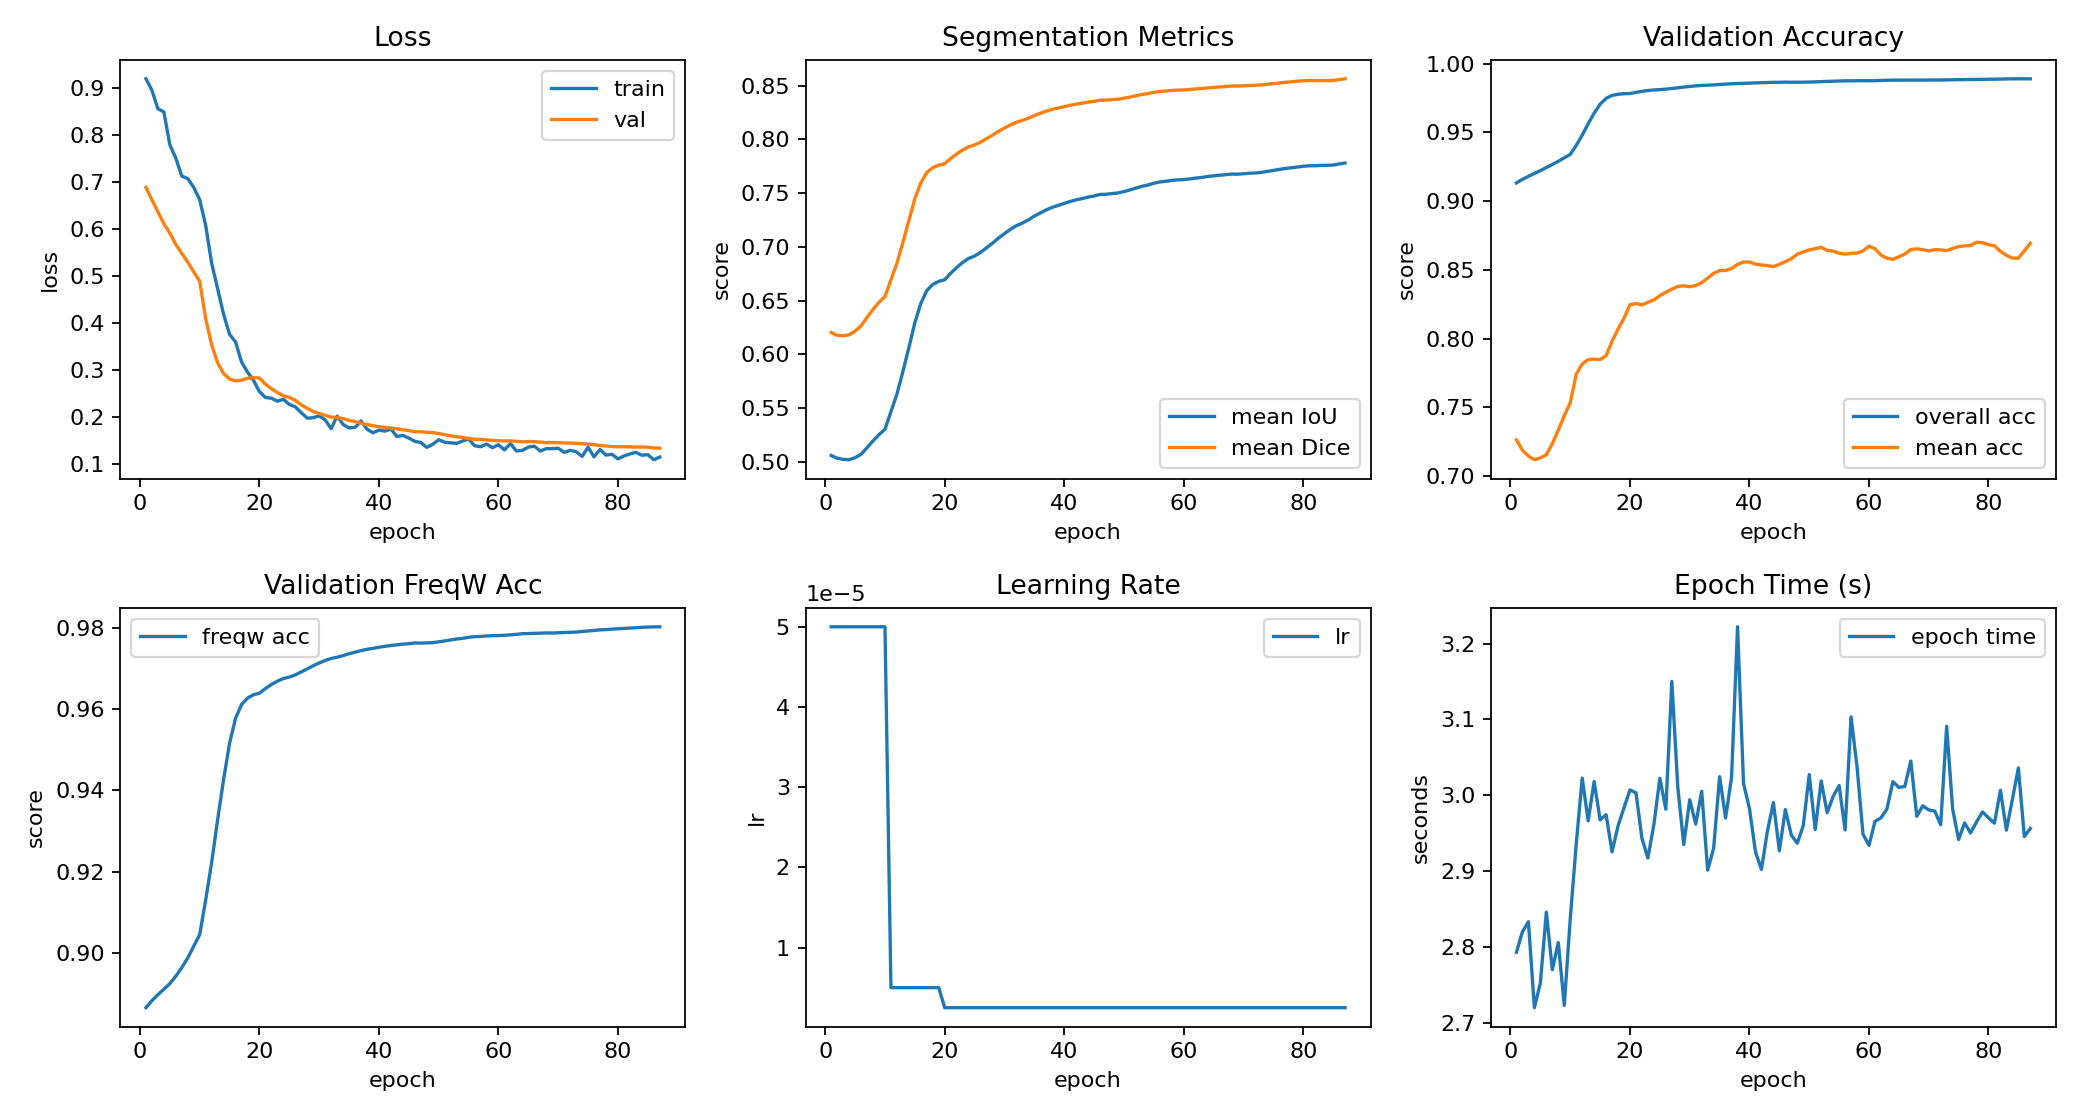

2026-02-20 19:16:12,675 INFO: Model saved as checkpoints/semantic/finetune/20260220190832-finetune[subset-0.2]-segformer_mit_b2_bean_semantic_real/model_current.pth
2026-02-20 19:16:13,407 INFO: Model saved as checkpoints/semantic/finetune/20260220190832-finetune[subset-0.2]-segformer_mit_b2_bean_semantic_real/model_best.pth
2026-02-20 19:16:13,408 INFO: Epoch 88/100: Avg Train Loss: 0.1195, Avg Val Loss: 0.1331, Mean IoU: 0.7782, Training time: 0:00:01, Validation time: 0:00:01


In [ ]:
DATASET = "bean_semantic_real"
trn_ds, val_ds, spec, split = build_dataset(
    dataset_id=DATASET,
    registry_path="data/datasets.yaml",
)

for x in range(1, 11):
    cfg = SemanticFinetuneConfig(
        model="segformer",
        encoder="mit_b2",
        dataset=DATASET,
        num_classes=4,
        batch_size=8,
        num_workers=4,
        lr=0.00005,
        epochs=100,
        use_amp=True,
        progress=True,
        ckpt="checkpoints/semantic/train/segformer_mitb2/model_best.pth",
        freeze_epochs=10,
    )


    trn_sb = make_fixed_subset(trn_ds, fraction=x/10.0, seed=42)
    trn_loader = DataLoader(trn_sb, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True, shuffle=True, drop_last=True,)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, num_workers=cfg.num_workers, pin_memory=True, shuffle=False,drop_last=False,)

    model = setup_model(cfg)
    load_pretrained_weights(model, cfg.ckpt, device=cfg.device, strict_load=cfg.strict_load)

    optimiser = build_optimiser(model, cfg.lr)
    scheduler = build_scheduler(optimiser)
    loss_fn = CEDiceLoss(ce_weight=0.5, dice_weight=0.5)

    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    cfg.output = os.path.join(cfg.output, f"{timestamp}-finetune[subset-{x/10.0}]-{model.name}")
    reporter = build_reporter(cfg=cfg, model_name = model.name)
    reporter = attach_notebook_viz(reporter, tail=5)
    path = finetune(
        model=model,
        train_loader=trn_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        cfg=cfg,
        reporter=reporter,
    )